<a href="https://colab.research.google.com/github/angelmorenocalvo/AprendiendoHTML/blob/master/Clasificador_Ropa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificion de imágenes de ropa

En este tutorial, entrenaremos una red neuronal para clasificar imagenes de ropa como botas, calcetines o camisetas.

## Dependencias
Necesitaremso la api de las bases de datos de TensorFLow, def esta forma nos resultara más sencillo el acceso a la base de datos.

In [3]:
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (1.3.0)


In [4]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
import tensorflow_datasets as tfds

import math
import numpy as np
import matplotlib.pyplot as plt

## Importar Fashion MNIST dataset

 Usaremos la base de datos Fashion MNIST, que contiene 70000 imagenes es escala de grises en 10 categorias. Las imágienes muestran articulos de ropa en una resolución de (28*28pixels), y se ven de la siguiente manera:

 <table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite" width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>
 

 Esta base de datos es usada muy a menudo como el hola mundo del machine learning para el computer vision. 

 Usaremos 60,000 imagenes pare el entrenamiento de la red neuronal, mientras que las 10,000 restantes serviran para evaluar la precisión de la clasificación por parte de la red.

 

In [0]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Cuando cargamos la base de datos nos retorna metadata al igual qeu la bases de datos de entrenamiento y test.
- El modelo se entrenara usando `train_dataset`.
- El modelo se testea con `test_dataset`.

Las imagenes seran arrays de 28*28, con pixeles que tienen rangos comprendidos de [0,28]. Las etiquetas seran arrays de enteros en un rango de [0,9].
Los cuales corresponden con:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Camiseta/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Pantalón</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Jersey</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Vestido</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Abrigo</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandalia</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Camisa</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Deportiva</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Mochila</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle Bota</td>
  </tr>
</table>

Cada imagen se asigna a una sola etiqueta. Dado que los nombres de clase no se incluyen con el conjunto de datos, los guardaremos en un array para usarlos más adelante al trazar las imágenes:


In [0]:
class_names = ['Camiseta/top', 'Pantalon', 'Jersey', 'Vestido', 'Abrigo', 'Sandalias', 'Camisa', 'Deportiva', 'Mochila', 'Bota']

## Exploremos los datos
Antes de entrenar camos a ver como son los datos del modelo. Con este código veremos qeu hay 60,000 imagenes en el set de entrenameitno y 10,000 en el set de de prueba:

In [8]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Número de ejemplos de entrenamiento:{}".format(num_train_examples))
print("Número de ejemplos de test:{}".format(num_test_examples))

Número de ejemplos de entrenamiento:60000
Número de ejemplos de test:10000


## Preprocesamiento de datos

El valor de cada pixel de los datos de la imagen es un entero en el rango [0,255]. Para que el modelo trabaje de forma apropiada, los valores tienen que ser normalizados en el rango [0,1]. Por lo que crearemos una función de normalización y la aplicaremos para cada imagen en ambos datasets.

In [0]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# La funcion map aplica la normalizacion de la funcion a cada elemento 
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# La primera vez que se use el dataset, la imagen sera descargada desde el disco
# El almacenamiento en caché los mantendrá en la memoria, haciendo que el 
# entrenamiento sea más rápido
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

## Explorando los datos procesados

vamos a mostrar la imagen.

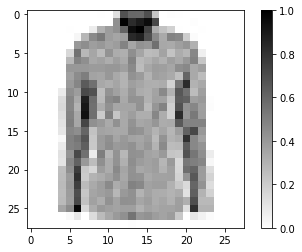

In [10]:
# Cogemos una sola imagen, y borramos la dimension del color con reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# mostrar la imagen
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()


Sacar por pantalla las primers 25 imagenes de los datasets con el nombre debajo de la imagen. Comprueba que los datos tienen el formato correcto y estan preparados para entrenar la red.

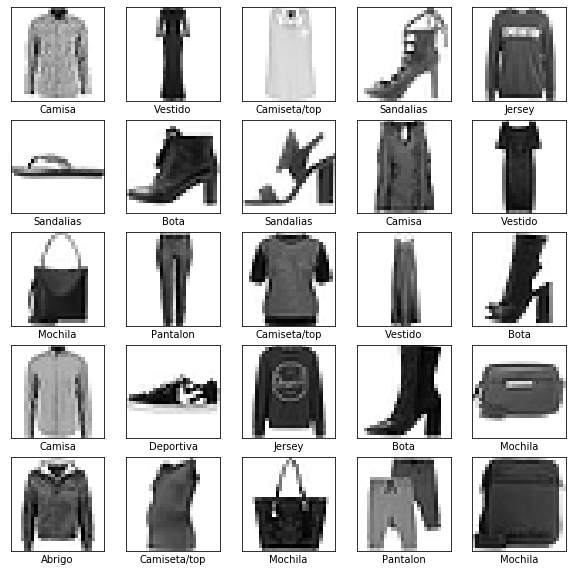

In [12]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(class_names[label])
  i+=1
plt.show()

# Desarrollando el modelo
El desarrollo de la red neuronal requiere configurar las capas del modelo y despues compilar el modelo.

### Configurar el modelo
Esta red contará con tres capas:
- **input** `tf.keras.kayers.Flatten` $\rightarrow$ Esta capa transforma las imagenes en dos dimensiones a un d-array de 784 pixels(28*28). Piensa que esta capa como el desapilado de las columnas de los pixeles en la imagen y aliniandolos. Esta capa no tiene parametros que aprendan, solo reforman los datos.
- **hidden** `tf.keras.layer.Dense` $\rightarrow$ Una capa de conexiones densas de 128 neuronas. Estas neuroanas o nodos tomas el input de los 748 nodos de la capa previa, los pesos del input de acuedo con los parametros que son enseñados durante el entrenamiento y outputs como un valor unico de la siguiente capa.
- **output** `tf.keras.layers.Dense` $\rightarrow$ 10 nodos de capa softmax, cada nodo representa una de las clases de ropa que tenemos en el modelo. Toma como in

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

### Compilar el modelo
Antes de qeu el modelo esté listo para ser entrenado, necesita algunas configuraciones más:
- **Loss funtion** $\rightarrow$
- **Optimizer** $\rightarrow$
- **Metrics** $\rightarrow$